# Progress Report on Model Development for 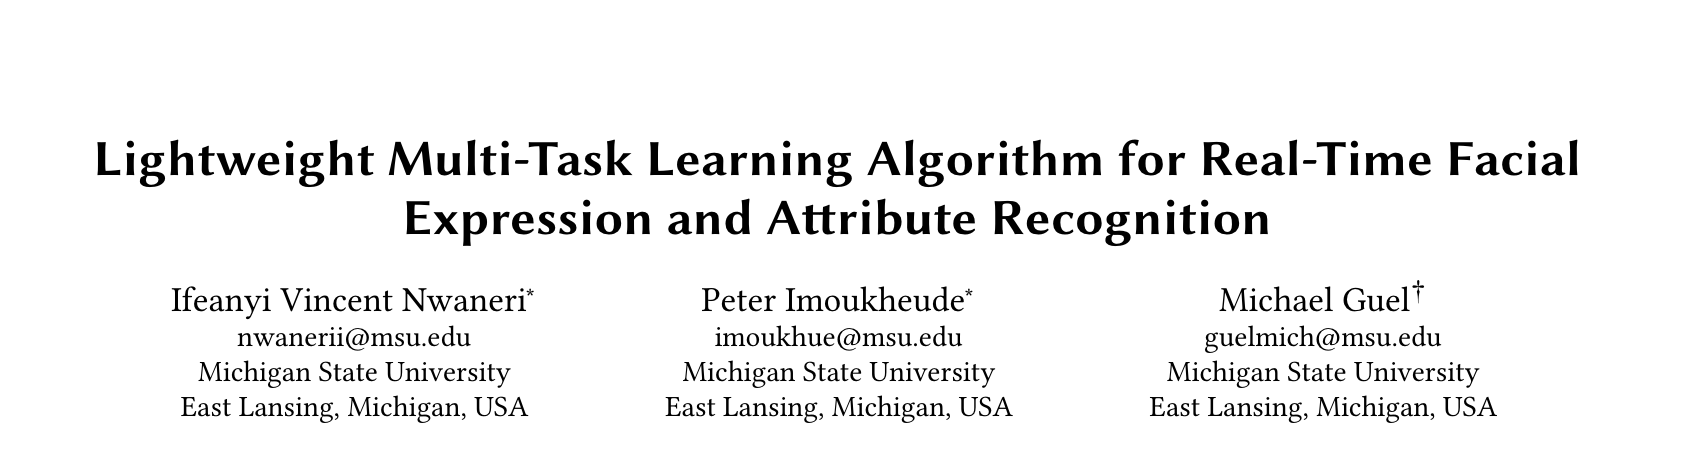

This project builds on the research by Savchenko (2021), leveraging a pretrained model to develop a multihead architecture for predicting age, gender, ethnicity, and emotion.

Currently, this notebook represents a preliminary implementation, with progress focused on predicting emotions. Other branches of the model are yet to be fully developed.

It is worth noting that we found the GitHub repository https://github.com/av-savchenko/face-emotion-recognition highly valuable, as most of the code was adapted from this resource.

# Importing Necessary Library

In [1]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from random import shuffle
import math

import pandas as pd

import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

from collections import defaultdict

import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model, model_from_json
from tensorflow.keras.applications import mobilenet, mobilenet_v2, densenet, inception_resnet_v2, inception_v3, vgg16, resnet_v2, resnet
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Activation, Conv2D, Reshape, DepthwiseConv2D, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, CSVLogger, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#from scipy.misc import imread, imresize

%matplotlib inline

# Definining Utility Functions

In [2]:
## Function to adjust Images bassed on facial landmarks to align properly 
def rotate_image(image, facial_landmarks):
    landmarks=np.array([float(l) for l in facial_landmarks.split(';')]).reshape((-1,2))
    left_eye_x=left_eye_y=right_eye_x=right_eye_y=0
    for (x,y) in landmarks[36:41]:
        left_eye_x+=x
        left_eye_y+=y
    for (x,y) in landmarks[42:47]:
        right_eye_x+=x
        right_eye_y+=y
    left_eye_x/=6
    left_eye_y/=6
    right_eye_x/=6
    right_eye_y/=6
    theta=math.degrees(math.atan((right_eye_y-left_eye_y)/(right_eye_x-left_eye_x)))
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    #print(left_eye_x, left_eye_y, right_eye_x, right_eye_y,theta,img.shape)
    return result

In [3]:
# This function preprocessees Unstructured images and saves to structured folder 

def save_images(filename,dir_to_save, same_size=-1, extractROI=True, rotate=False):
    affect_df = pd.read_csv(filename)
    affect_vals=[d for i,d in affect_df.iterrows()]
    for d in log_progress(affect_vals):
        #print(d.subDirectory_filePath,d.face_x,d.face_y, d.face_width, d.face_height, d.expression)
        if d.expression>=len(emotion_labels) or d.face_width<0:
            continue
        input_path=os.path.join(IMG_AFFECT_DATA_DIR,d.subDirectory_filePath)
        outdir_path=os.path.join(dir_to_save,emotion_labels[d.expression])
        if not os.path.exists(outdir_path):
            os.makedirs(outdir_path)
        dst_file_path=os.path.join(outdir_path,os.path.basename(d.subDirectory_filePath))
        #print(input_path,dst_file_path)
        if not os.path.exists(dst_file_path):
            if extractROI:
                img=cv2.imread(input_path)
                x,y=int(d.face_x),int(d.face_y)
                w,h=int(d.face_width),int(d.face_height)
                area=img[y:y+h,x:x+w]
                if rotate:
                    area=rotate_image(area,d.facial_landmarks)
                if same_size>0:
                    area = cv2.resize(area,(same_size,same_size))
                cv2.imwrite(dst_file_path,area)
            else:
                os.symlink(input_path,dst_file_path)
        else:
            print('duplicate, several faces?',d.subDirectory_filePath)

In [4]:
# This will be used to display progress when processing a sequence of items

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [5]:
# Define save_model function
def save_model(model, filename):
    model.save_weights('weights.h5')
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)

    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('weights.h5')
    loaded_model.save(filename)


# The Data

In [6]:
# Set the base directory for dataset
base_dir = "organized_dataset"

# Initialize counters to know the distribution of the dataset
split_counts = {'train': 0, 'val': 0, 'test': 0}
class_counts = defaultdict(int)

# Iterate over train, val, and test splits
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(base_dir, split)
    if os.path.isdir(split_dir):
        # Iterate over classes in each split
        for cls in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, cls)
            if os.path.isdir(class_dir):
                num_images = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
                class_counts[cls] += num_images
                split_counts[split] += num_images

# Print the counts for each split
print("Dataset Split Counts:")
for split, count in split_counts.items():
    print(f"{split.capitalize()} Samples: {count}")

Dataset Split Counts:
Train Samples: 10249
Val Samples: 2197
Test Samples: 2202


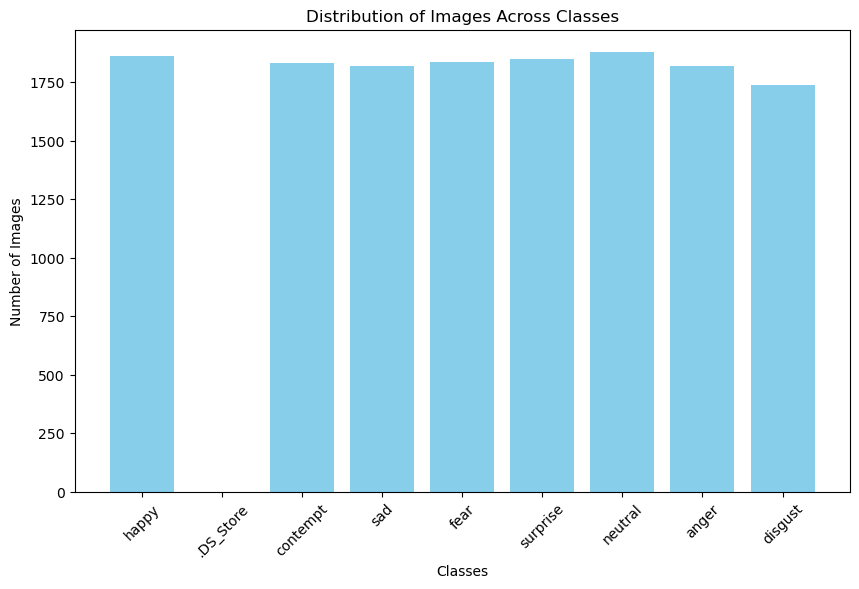

In [7]:
# Display the distribution as a histogram
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.title("Distribution of Images Across Classes")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

### The dataset is balanced 

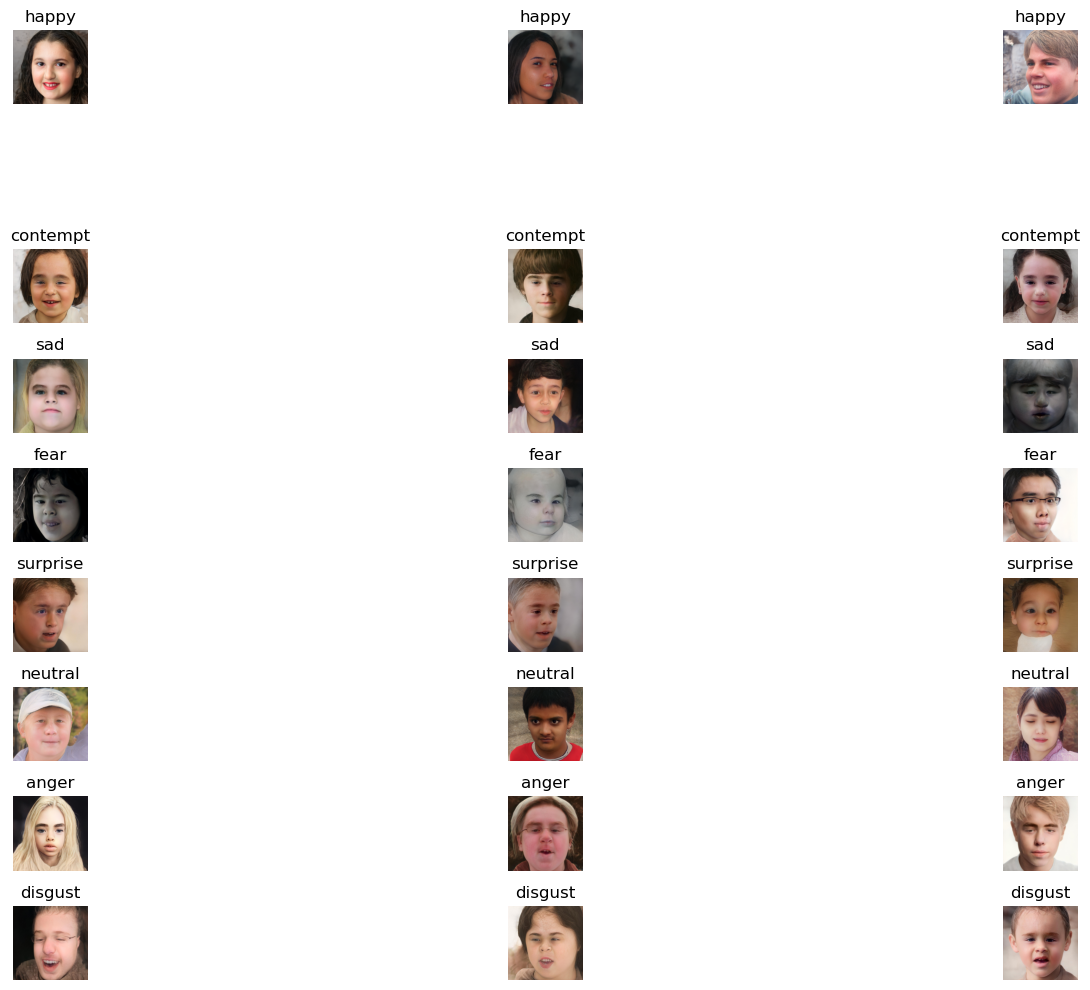

In [8]:
# Visualize some images from each class
num_images_to_display = 3  # Number of images to display per class
plt.figure(figsize=(15, 10))

for i, cls in enumerate(class_counts.keys()):
    # Collect all images from train/val/test for the current class
    images = []
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(base_dir, split)
        class_dir = os.path.join(split_dir, cls)
        if os.path.isdir(class_dir):
            images.extend([os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
    
    # Display images
    for j in range(min(num_images_to_display, len(images))):
        img_path = images[j]
        img = Image.open(img_path)
        
        plt.subplot(len(class_counts), num_images_to_display, i * num_images_to_display + j + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(cls)

plt.tight_layout()
plt.show()

# preparing the data 

In [9]:
train_data_dir, val_data_dir = "organized_dataset/train", "organized_dataset/val"
print(train_data_dir, val_data_dir)

organized_dataset/train organized_dataset/val


# Defining the Model



In [10]:
# Set input size and batch size
INPUT_SIZE = (224, 224)
BATCH_SIZE = 40

In [11]:
# Enable GPU memory growth (useful to prevent memory preallocation issues)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print("Error enabling GPU memory growth:", e)
else:
    print("No GPU detected")

# Print the name of the detected GPU
print("TF Device:", tf.test.gpu_device_name())

GPU memory growth enabled
TF Device: /device:GPU:0


2024-11-21 12:40:19.526993: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-11-21 12:40:19.527024: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2024-11-21 12:40:19.527029: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
2024-11-21 12:40:19.527046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 12:40:19.527056: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
# choosing pretrainied model: change the outer to statement to True to use mobilenet or inception

if True:
    if True:
        net_model=mobilenet
        net_description='mobilenet_v1'
        INPUT_SIZE = (224, 224)
        BATCH_SIZE=80
        base_model = mobilenet.MobileNet(input_shape=(INPUT_SIZE[0],INPUT_SIZE[1],3), include_top=True, weights='imagenet')
    else:
        net_model=inception_v3
        net_description='inception_v3'
        INPUT_SIZE = (299, 299)
        BATCH_SIZE=32
        base_model = inception_v3.InceptionV3(input_shape=(INPUT_SIZE[0],INPUT_SIZE[1],3), include_top=True, weights='imagenet')
    preprocessing_function=net_model.preprocess_input
else:
    base_model=load_model('../../models/pretrained_faces/age_gender_tf2_224_deep-03-0.13-0.97.h5')
    base_model.summary()
    net_description='mobilenet_face'
    def mobilenet_preprocess_input(x,**kwargs):
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68
        return x
    preprocessing_function=mobilenet_preprocess_input
        
    BATCH_SIZE=80
    INPUT_SIZE = (224, 224)

2024-11-21 12:40:19.534043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-21 12:40:19.534058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
target_size=INPUT_SIZE
print(target_size)

(224, 224)


In [14]:
net_description='affectnet_'+net_description

# Preparing the data

In [15]:
if False:
    train_datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, 
                                   samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06,
                                   rotation_range=0.1, width_shift_range=-0.1, height_shift_range=-0.1, brightness_range=None, shear_range=0.0, 
                                   zoom_range=0.1, channel_shift_range=1.05, fill_mode='nearest', horizontal_flip=True, vertical_flip=False,
                                   preprocessing_function=preprocessing_function)
else:
    train_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

In [16]:
val_generator = test_datagen.flow_from_directory(
    val_data_dir, target_size=target_size,
    batch_size=BATCH_SIZE, class_mode='categorical',follow_links=True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir, target_size=target_size,
    batch_size=BATCH_SIZE, class_mode='categorical',follow_links=True)

Found 2197 images belonging to 9 classes.
Found 10249 images belonging to 9 classes.


In [17]:
N_CLASS=val_generator.num_classes
nb_train_samples=train_generator.samples
nb_validation_samples=val_generator.samples
print(N_CLASS,nb_train_samples,nb_validation_samples)

class_to_idx=val_generator.class_indices
idx_to_class={class_to_idx[cls]:cls for cls in class_to_idx}
print(idx_to_class)

9 10249 2197
{0: '.DS_Store', 1: 'anger', 2: 'contempt', 3: 'disgust', 4: 'fear', 5: 'happy', 6: 'neutral', 7: 'sad', 8: 'surprise'}


In [18]:
# Wrap train_generator and val_generator into tf.data.Dataset

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 9), dtype=tf.float32),
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 9), dtype=tf.float32),
    )
)

In [19]:
(unique, counts) = np.unique(train_generator.classes, return_counts=True)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights, idx_to_class, val_generator.class_indices)

[1275 1283 1217 1287 1303 1315 1274 1295] {1: 1.031372549019608, 2: 1.0249415432579891, 3: 1.0805258833196385, 4: 1.0217560217560218, 5: 1.0092095165003838, 6: 1.0, 7: 1.032182103610675, 8: 1.0154440154440154} {0: '.DS_Store', 1: 'anger', 2: 'contempt', 3: 'disgust', 4: 'fear', 5: 'happy', 6: 'neutral', 7: 'sad', 8: 'surprise'} {'.DS_Store': 0, 'anger': 1, 'contempt': 2, 'disgust': 3, 'fear': 4, 'happy': 5, 'neutral': 6, 'sad': 7, 'surprise': 8}


# Compiling the model 

In [20]:
#choosing the layer of the base model to attach the head

if True:
    x=base_model.layers[-2].output
else:
    layer_name='feats'
    #layer_name='global_average_pooling2d_1'
    #layer_name='fca7/relu'
    layer_out=base_model.get_layer(layer_name) #'global_pooling') #
    x=layer_out.output

emotion_preds = Dense(N_CLASS, activation='softmax', name='emotion_preds')(x)
model=Model(base_model.input,emotion_preds)
start_epoch=0

In [21]:
#Freeze other layers 

base_model.trainable=False
for l in base_model.layers:
    l.trainable=False
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,262,873 (16.26 MB)

 Trainable params: 9,009 (35.19 KB)

 Non-trainable params: 4,253,864 (16.23 MB)

In [22]:
print(net_description)

affectnet_mobilenet_v1


In [23]:
mc = ModelCheckpoint(net_description + '.keras', monitor='val_accuracy', verbose=1, save_best_only=True)

In [24]:
mc = ModelCheckpoint(net_description+'.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
es=EarlyStopping(monitor='val_accuracy',patience=2)
FIRST_EPOCHS=3

In [25]:
# Train the model
hist1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=FIRST_EPOCHS,
    steps_per_epoch=nb_train_samples // BATCH_SIZE,
    validation_steps=nb_validation_samples // BATCH_SIZE,
    callbacks=[mc, es],
    class_weight=class_weights,
)

Epoch 1/3


2024-11-21 12:40:20.773597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-11-21 12:40:20.774443: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.2238 - loss: 2.7831

2024-11-21 12:41:47.516399: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 1: val_accuracy improved from -inf to 0.33843, saving model to affectnet_mobilenet_v1.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 106s 820ms/step - accuracy: 0.2242 - loss: 2.7793 - val_accuracy: 0.3384 - val_loss: 1.8334
Epoch 2/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.3529 - loss: 1.8488
Epoch 2: val_accuracy improved from 0.33843 to 0.37081, saving model to affectnet_mobilenet_v1.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 90s 711ms/step - accuracy: 0.3531 - loss: 1.8483 - val_accuracy: 0.3708 - val_loss: 1.6883
Epoch 3/3
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.3975 - loss: 1.7013
Epoch 3: val_accuracy improved from 0.37081 to 0.38309, saving model to affectnet_mobilenet_v1.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 88s 694ms/step - accuracy: 0.3976 - loss: 1.7011 - val_accuracy: 0.3831 - val_loss: 1.6378


### Unfreezing other layer

In [26]:
# Calculate the starting epoch from the first training phase
start_epoch = len(hist1.history['loss'])

# Unfreeze all layers of the base model for fine-tuning
for l in base_model.layers:
    l.trainable = True

# Load the best model weights from the first training phase
model.load_weights(net_description + '.keras')

# Compile the model with a smaller learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-4, decay=1e-6), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Display the model architecture
model.summary()

/opt/anaconda3/envs/face-expression2/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,262,873 (16.26 MB)

 Trainable params: 4,240,985 (16.18 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [27]:
# Define the total number of epochs for fine-tuning
SECOND_EPOCHS = start_epoch + 5

# Setup ModelCheckpoint to save the best model during fine-tuning
mc = ModelCheckpoint(net_description + '_ft.keras', 
                     monitor='val_accuracy', 
                     verbose=1, 
                     save_best_only=True)

# Fine-tuning phase
print("Starting Fine-Tuning...")
hist2 = model.fit(
    train_dataset,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=SECOND_EPOCHS,
    verbose=1,
    initial_epoch=start_epoch,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[mc],
    class_weight=class_weights
)

Starting Fine-Tuning...
Epoch 4/8


2024-11-21 12:45:07.334063: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.3669 - loss: 2.1929

/opt/anaconda3/envs/face-expression2/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-21 12:46:40.091256: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 4: val_accuracy improved from -inf to 0.41713, saving model to affectnet_mobilenet_v1_ft.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 113s 832ms/step - accuracy: 0.3673 - loss: 2.1904 - val_accuracy: 0.4171 - val_loss: 1.9783
Epoch 5/8
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.5753 - loss: 1.2211
Epoch 5: val_accuracy did not improve from 0.41713
128/128 ━━━━━━━━━━━━━━━━━━━━ 77s 606ms/step - accuracy: 0.5754 - loss: 1.2206 - val_accuracy: 0.4054 - val_loss: 2.1964
Epoch 6/8


2024-11-21 12:48:15.949584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-21 12:48:15.949604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/opt/anaconda3/envs/face-expression2/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.6702 - loss: 0.9305
Epoch 6: val_accuracy improved from 0.41713 to 0.45972, saving model to affectnet_mobilenet_v1_ft.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 107s 840ms/step - accuracy: 0.6703 - loss: 0.9304 - val_accuracy: 0.4597 - val_loss: 1.7048
Epoch 7/8
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.7556 - loss: 0.7208
Epoch 7: val_accuracy did not improve from 0.45972
128/128 ━━━━━━━━━━━━━━━━━━━━ 76s 597ms/step - accuracy: 0.7555 - loss: 0.7208 - val_accuracy: 0.3243 - val_loss: 1.8152
Epoch 8/8


2024-11-21 12:51:19.277765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-21 12:51:19.277786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.8062 - loss: 0.5864
Epoch 8: val_accuracy did not improve from 0.45972
128/128 ━━━━━━━━━━━━━━━━━━━━ 108s 841ms/step - accuracy: 0.8061 - loss: 0.5865 - val_accuracy: 0.4176 - val_loss: 2.1822


In [29]:
# if False:
#     save_model(model, '../../models/final_model.keras')
# else:
#     model = load_model('../../models /final_model.keras')
#     model.summary()

In [30]:
USE_PREPROCESSING=True
print(INPUT_SIZE)

(224, 224)


In [ ]:
y_val=np.array(val_generator.labels)
y_scores_val=[]
#model.load_weights(net_description+'_ft.h5')
for filepath in log_progress(val_generator.filepaths):
    img=cv2.imread(filepath)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,INPUT_SIZE)
    if USE_PREPROCESSING:
        inp = preprocessing_function(np.expand_dims(img, axis=0).astype(np.float32))
    else:
        inp=img.astype(np.float32)
        inp[..., 0] -= 103.939
        inp[..., 1] -= 116.779
        inp[..., 2] -= 123.68
        inp = np.expand_dims(inp, axis=0)

    scores=model.predict(inp)
    #print(scores.shape)
    y_scores_val.append(scores)

y_scores_val=np.concatenate(y_scores_val, axis=0)
print(y_scores_val.shape,y_val.shape)

2024-11-21 14:11:00.253911: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━

In [34]:
y_pred=np.argmax(y_scores_val,axis=1)
acc=100.0*(y_val==y_pred).sum()/len(y_val)
print('Accuracy:',acc)

y_train=np.array(train_generator.labels)

for i in range(y_scores_val.shape[1]):
    _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()
    print('%s %d/%d acc: %f' %(idx_to_class[i],(y_train==i).sum(),(y_val==i).sum(),100*_val_acc))

Accuracy: 41.69321802457897
.DS_Store 0/0 acc: nan
anger 1275/273 acc: 17.582418
contempt 1283/275 acc: 24.363636
disgust 1217/261 acc: 39.846743
fear 1287/276 acc: 21.376812
happy 1303/279 acc: 74.551971
neutral 1315/282 acc: 68.085106
sad 1274/273 acc: 6.227106
surprise 1295/278 acc: 79.496403


/var/folders/r0/mdrnq25s5nnb7l0k1pd_89pm0000gn/T/ipykernel_90521/3765228234.py:8: RuntimeWarning: invalid value encountered in scalar divide
  _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()


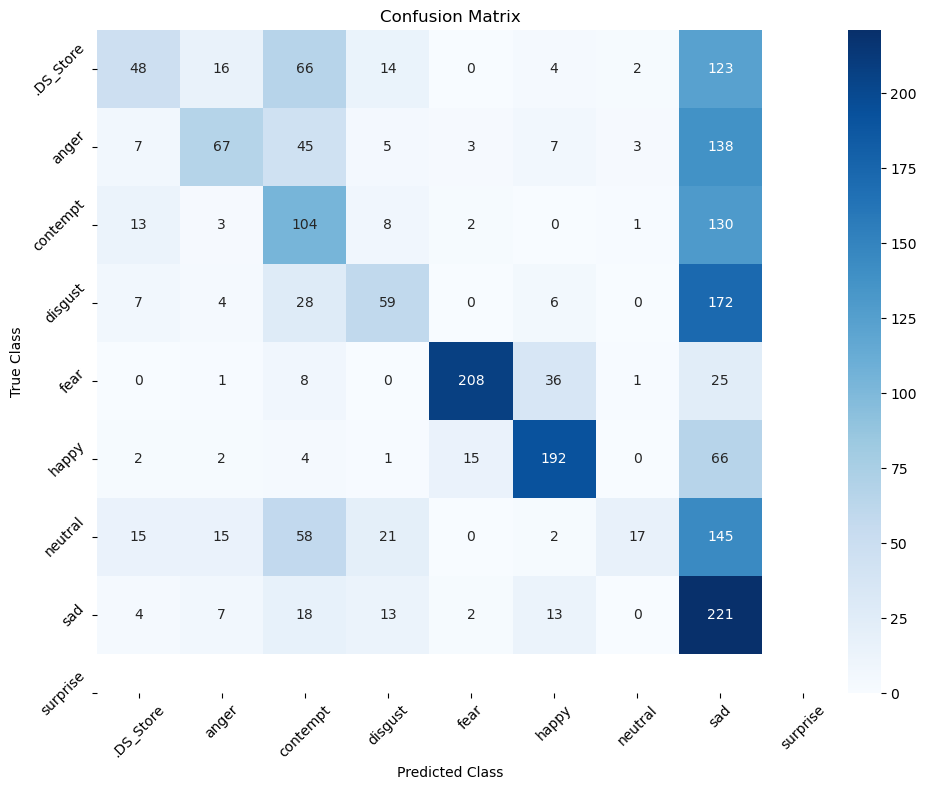

In [35]:
# Generate the confusion matrix
y_pred = np.argmax(y_scores_val, axis=1)
cm = confusion_matrix(y_val, y_pred)

# Define class names (replace these with your class names)
class_names = list(idx_to_class.values())

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()